## Амангелді Нұрғалым > IWS 12-13

<a id='2'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Импорт и установка библиотек</b>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # линейная алгебра
import pandas as pd # обработка данных, ввод-вывод CSV-файла (например, pd.read_csv)

# Библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки машинного обучения
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

# Библиотеки для обработки текста
import nltk
from nltk.stem import PorterStemmer
import os

# Загружаем набор данных

In [3]:
df=pd.read_csv('/Users/LENOVO/DESKTOP/Весь материал Нургалыма/jupyter/Final_suicide.csv')
df.head()

,text,class
0,"How the fuck do you do it?I don't want to die,...",suicide
1,I don't know how much longer I can go on forI ...,suicide
2,Suicide pact time: I will commit suicide a yea...,suicide
3,Opiod ODIn theory\n\nwould it be difficult to ...,suicide
4,Now reciting SBB members Hello as one of our 4...,non-suicide


In [6]:
df['class'].value_counts()

suicide        32022
non-suicide    32017
Name: class, dtype: int64

# Визуализация данных

suicide        32022
non-suicide    32017
Name: class, dtype: int64


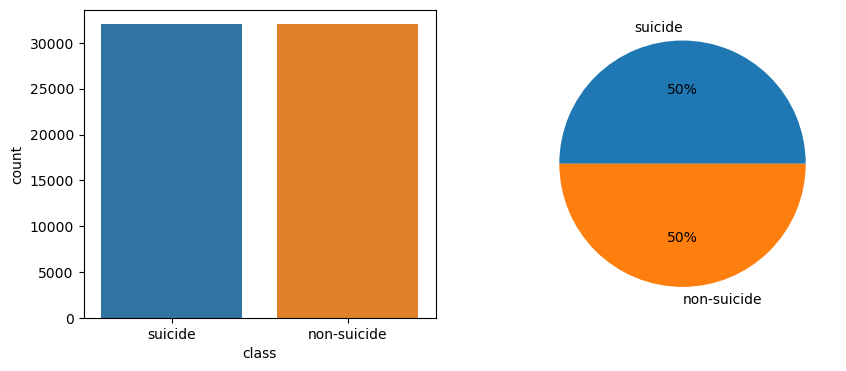

In [7]:
classCnt = df['class'].value_counts()
print(classCnt)

plt.figure(figsize=((10,4)))

plt.subplot(1,2,1)
sns.countplot(df,x='class')

plt.subplot(1,2,2)
plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

plt.show()

# Предварительная обработка текста

#### Опускание текста в нижний регистр

In [8]:
df['text']= df['text'].str.lower()

#### Убрать знаки препинания

In [9]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)

#### Удаление стоп-слова

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#### Токенизация

In [11]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))
df.head()

,text,class
0,"[fuck, iti, dont, want, die, posting, fuck, li...",suicide
1,"[dont, know, much, longer, go, fori, made, red...",suicide
2,"[suicide, pact, time, commit, suicide, year, k...",suicide
3,"[opiod, odin, theory, would, difficult, get, b...",suicide
4,"[reciting, sbb, members, hello, one, 4, founde...",non-suicide


#### Стемминг

In [12]:
ps = PorterStemmer()
df['text'] = df['text'].apply(lambda x : [ps.stem(i) for i in x])

In [13]:
df['text']=df['text'].apply(lambda x : ' '.join(x))
df.head()

,text,class
0,fuck iti dont want die post fuck live depress ...,suicide
1,dont know much longer go fori made reddit acco...,suicide
2,suicid pact time commit suicid year know life ...,suicide
3,opiod odin theori would difficult get benzosf ...,suicide
4,recit sbb member hello one 4 founder allow exp...,non-suicide


In [10]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Машинное обучение - Выбор модели

In [17]:
x,y = df['text'],df['class']

# TF-IDF-векторизатор

In [18]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [19]:
# Save the model
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)   

In [20]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=7)

In [21]:
X_train.shape,X_test.shape

((51231, 3808), (12808, 3808))

# Наивный Байесовский классификатор (классификатор голосования)

In [22]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.9011926372704027
Testing score: 0.8967832604622111


              precision    recall  f1-score   support

 non-suicide       0.89      0.91      0.90      6439
     suicide       0.90      0.89      0.90      6369

    accuracy                           0.90     12808
   macro avg       0.90      0.90      0.90     12808
weighted avg       0.90      0.90      0.90     12808



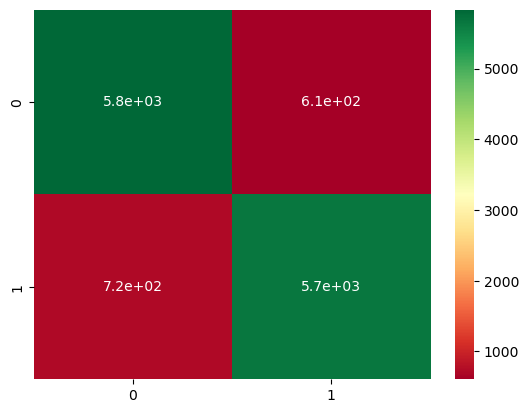

In [23]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='RdYlGn')
print(classification_report(y_act,y_pred))

# Random Forest

In [24]:
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],
                                                      'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=10)
classifiers.fit(X_train, y_train)
print('Training score:',classifiers.score(X_train, y_train))
print('Testing score:',classifiers.score(X_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.759832913665554
Testing score: 0.771627108057464
RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=5)


              precision    recall  f1-score   support

 non-suicide       0.77      0.90      0.83      6439
     suicide       0.88      0.72      0.79      6369

    accuracy                           0.81     12808
   macro avg       0.82      0.81      0.81     12808
weighted avg       0.82      0.81      0.81     12808



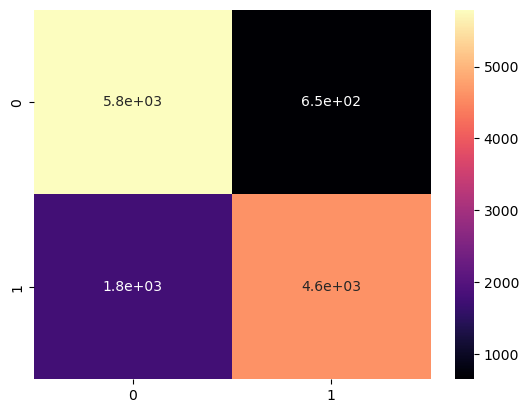

In [37]:
y_act=y_test
y_pred=classifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='magma')
print(classification_report(y_act,y_pred))

# Decision Tree (Дерево решений)

In [25]:
model2 = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=70,max_depth=4,random_state=7)
model2.fit(X_train, y_train)
print(model2.score(X_train, y_train))
print(model2.score(X_test,y_test))

0.7361168042786594
0.7408650843222986


              precision    recall  f1-score   support

 non-suicide       0.68      0.84      0.75      6439
     suicide       0.79      0.61      0.69      6369

    accuracy                           0.73     12808
   macro avg       0.74      0.72      0.72     12808
weighted avg       0.74      0.73      0.72     12808



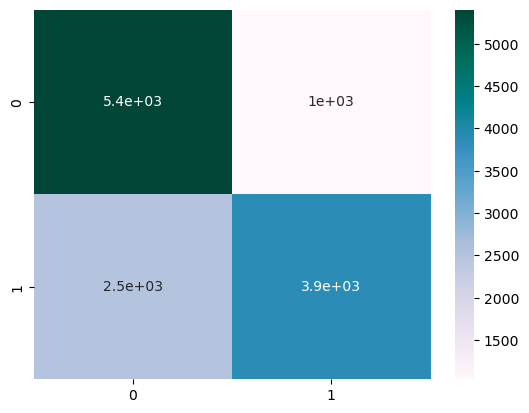

In [39]:
y_act=y_test
y_pred=model2.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PuBuGn')
print(classification_report(y_act,y_pred))

# Gradient Boosting (Повышение градиента)

In [ ]:
model3 = RandomizedSearchCV(GradientBoostingClassifier(),{"learning_rate": range(3,5),
                "max_depth":[200],"max_features":range(6,10,2),
                 "n_estimators":[10]},random_state=0,n_jobs=-1)
model3.fit(X_train,y_train)
print('Training score:',model3.score(X_train,y_train))
print('Testing score:',model3.score(X_test,y_test))
model3.best_params_

              precision    recall  f1-score   support

 non-suicide       0.79      0.80      0.80       725
     suicide       0.81      0.81      0.81       775

    accuracy                           0.80      1500
   macro avg       0.80      0.80      0.80      1500
weighted avg       0.80      0.80      0.80      1500



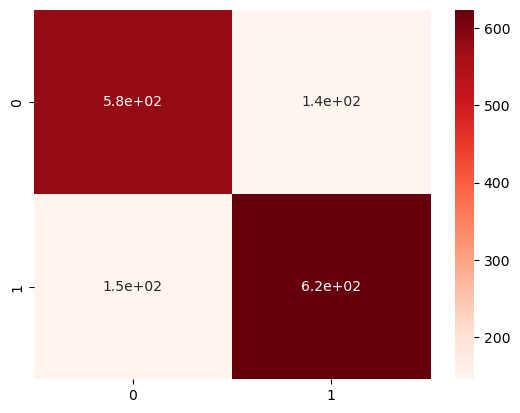

In [50]:
#матрица путаницы и отчет о классификации
y_act=y_test
y_pred=model3.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Reds')
print(classification_report(y_act,y_pred))

# XG Boost

In [51]:
model = XGBClassifier( eval_metric='map',max_depth=200,n_estimators=70,learning_rate=1.99)
model.fit(X_train,y_train.replace({"non-suicide":0,'suicide':1}))
print('Training score:',model.score(X_train,y_train.replace({"non-suicide":0,'suicide':1})))
print('Testing score:',model.score(X_test,y_test.replace({"non-suicide":0,'suicide':1})))

Training score: 0.9982857142857143
Testing score: 0.8406666666666667


              precision    recall  f1-score   support

           0       0.83      0.84      0.84       725
           1       0.85      0.84      0.85       775

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



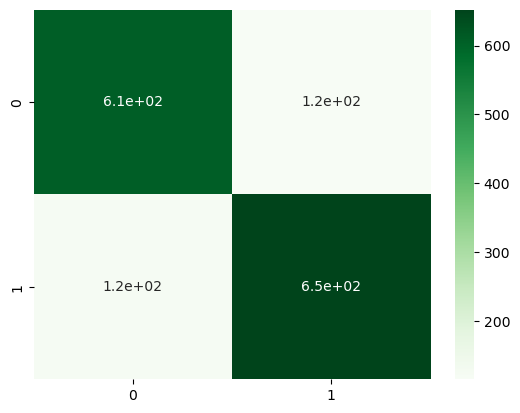

In [52]:
#матрица путаницы и отчет о классификации
y_act = y_test.replace({"non-suicide":0,'suicide':1})
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Greens')
print(classification_report(y_act,y_pred))

# K-Nearest Neighbour (K-Ближайший сосед)

In [61]:
model = RandomizedSearchCV(KNeighborsClassifier(),{'n_neighbors':[8],'metric':['manhattan','minkowski','cosine','tanimoto'],
                                                   'p':[1,2]},random_state=0,n_jobs=-1)
model.fit(X_train, y_train)
print('Training score:',model.score(X_train, y_train))
print('Testing score:',model.score(X_test,y_test))
print(model.best_estimator_)

Training score: 0.8754285714285714
Testing score: 0.8226666666666667
KNeighborsClassifier(metric='cosine', n_neighbors=8, p=1)


              precision    recall  f1-score   support

 non-suicide       0.78      0.87      0.83       725
     suicide       0.87      0.78      0.82       775

    accuracy                           0.82      1500
   macro avg       0.83      0.82      0.82      1500
weighted avg       0.83      0.82      0.82      1500



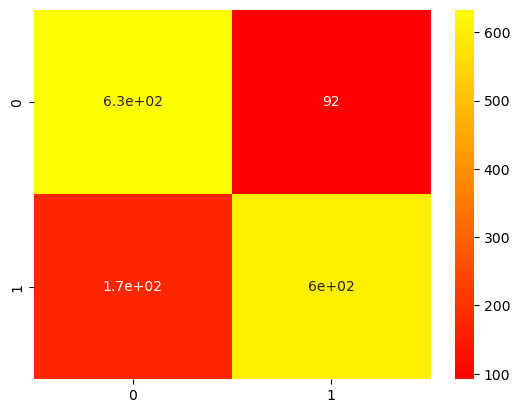

In [62]:
y_act = y_test
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='autumn')
print(classification_report(y_act,y_pred))

# Вывод
### Исходя из вышеизложенного, мы можем сказать, что из всех моделей наивный Байес (классификатор голосования) является наиболее подходящей моделью для набора данных.
### Точность : 90%

# Анализатор текста с моделью Naive Bayes

In [ ]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(VotingClassifiers, f)  

In [ ]:
# Пример функции для лемматизации слова
def lemmatize_word(word):
    parsed_word = morph.parse(word)[0]
    return parsed_word.normal_form

In [64]:
def preprocess(inp):
    inp = inp.lower() #преобразовать в нижний регистр
    inp = inp.replace(r'[^\w\s]+', '') #убрать знаки препинания
    inp = [word for word in inp.split() if word not in (stop_words)] #токенизация предложение
    inp = ' '.join([lemmatize_word(i) for i in inp.split()])
    inputToModel = vectorizer.transform([inp]).toarray() #преобразовать в векторную форму
    return inputToModel

In [65]:
def app(input_text):
    # Определите текстовое поле ввода
    print('Input : ',input_text) #принимать вводимые данные от пользователя
    processed_array = preprocess(input_text) #предварительная обработка текста
    predict = VotingClassifiers.predict(processed_array) #Прогнозирование модели
    print('Output : ', predict[0])

In [66]:
app('Today evening, I am going to jump off the bridge ')

Input :  Today evening, I am going to jump off the bridge 
Output :  suicide


In [67]:
app('Thoughts of death do not leave me alone. I regret all the loans, that I tied up my family')

Input :  Thoughts of death do not leave me alone. I regret all the loans, that I tied up my family
Output :  suicide


In [73]:
app('Have a nice day!')

Input :  Have a nice day!
Output :  non-suicide


In [74]:
app('I feel bad and want to die')

Input :  I feel bad and want to die
Output :  suicide
